# DEEE725 Speech Signal Processing Lab
### 2023 Spring, Kyungpook National University 
### Instructor: Gil-Jin Jang

## Lab 04 Spectral subtraction, Wiener filtering, end point detectoin, voice activity detection
2023/04/07

----
### import packages, define analysis parameters and draw parameters, etc.

In [1]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

# display wav files
import IPython

신호 분석과 스펙트럼을 그리기 위한 다음의 parameter 들을 정의한다.
입력 파일의 sampling frequency 를 이용하여 shift size 를 sample 수로 정의하기 위해 사용된다.
- `Ts`: shift length in seconds, default 0.01 sec = 10 ms. 
- `Tf`: frame length in seconds, default 0.02 sec = 20 ms

In [2]:
# parameters for signal analysis
# Fs = 16000  native sampling frequency (wav file 에 정의된 것) 을 사용하면 필요 없음
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

spectrum 을 그리기 위한 parameters.
- `cmap_plot`: colormap. default value is `pyplot.cm.bone_r` (최소값 흰색, 최대값 검은색 의 gray scale) 

In [3]:
# parameters for drawing
#cmap_plot = plt.cm.bone # default colormap for spectrogram, gray
cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
#cmap_plot = plt.cm.plasma 
#cmap_plot = plt.cm.inferno
#FIG_SIZE = (15,10)   # obsolete
FIG_SIZE = (8,3)

---
### 이전 lab 들에서 정의한 함수들

In [4]:
# draw spectrogram
from gjdrawspectrogram3 import drawspectrogram3

# linear phase FIR filter design from magnitudes of the frequency components
from gjfiroverlapadd import getLPHFIRFFT

# trapezoidal overlap add for FIR filtering
from gjfiroverlapadd import firoverlapadd

---
### load speech and noise

오디오 파일들의 경로 정의

In [5]:
audioinputpath = '../audio'
outpath = 'out'

# add '/' if path is not a null string
def addpath(path, file):
    if len(path) == 0: 
        return file
    else:
        return path + '/' + file

다음의 두 개의 파일을 이용하여 speech 와 noise의 특성을 비교하여 본다.

In [6]:
speechfile = addpath(audioinputpath, 'gjang-kdigits0-3.wav')
noisefile  = addpath(audioinputpath, 'car.wav')

__load files in windows wav format__
- `librosa.load()`는 $-1 \sim 1$
- 읽어들인 sampling frequency $F_s$ 를 이용하여 frame size $N_f$, shift size $N_s$를 계산한다.
- FFT (fast Fourier transform) 크기는 $N_f$ 보다 크거나 같은 2의 거듭제곱으로 FFT 크기 $N_{FFT}$ 을 정의함
$$ N_{FFT} = 2^{\lceil \log_{2} N_{f} \rceil} $$

In [7]:
# load audio files with Librosa
speech, Fs = librosa.load(speechfile, sr=None, mono='True')
noise, _ = librosa.load(noisefile, sr=Fs, mono='True')
# sr: target sampling rate. ‘None’ uses the native sampling rate
# mono = True: convert signal to mono

print(speechfile, speech.shape, speech)
print(noisefile, noise.shape, noise)

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
hNo = NFFT//2+1
print('Fs = %d, Ns = %d, Nf = %d, NFFT = %d, hNo = %d' % (Fs, Ns, Nf, NFFT, hNo))

../audio/gjang-kdigits0-3.wav (37952,) [-4.7912598e-03 -3.7231445e-03 -3.3569336e-03 ... -3.0517578e-05
 -8.8500977e-04  8.5449219e-04]
../audio/car.wav (175745,) [-0.01342773 -0.0222168  -0.02905273 ... -0.0390625  -0.03930664
 -0.04086304]
Fs = 16000, Ns = 160, Nf = 320, NFFT = 512, hNo = 257


array([[  0.98169835, -48.88611563,   3.1324693 , ...,  -9.12823462,
          2.7801733 ,   1.09309141],
       [ 15.65259614,  16.00577403,  16.22904319, ...,  13.82631938,
         15.76671355,  17.55505021],
       [ 15.55749858,  17.52033179,  17.45295515, ...,  18.98548141,
         19.86723635,  19.6122841 ],
       ...,
       [-68.11610281, -60.06479629, -62.70839477, ..., -49.39283694,
        -45.83500294, -56.26431093],
       [-54.83801771, -52.36526795, -56.37173569, ..., -50.60357958,
        -46.87544314, -60.39318112],
       [-66.43200604, -53.80243152, -73.95182647, ..., -48.89061985,
        -46.85413105, -52.25941962]])

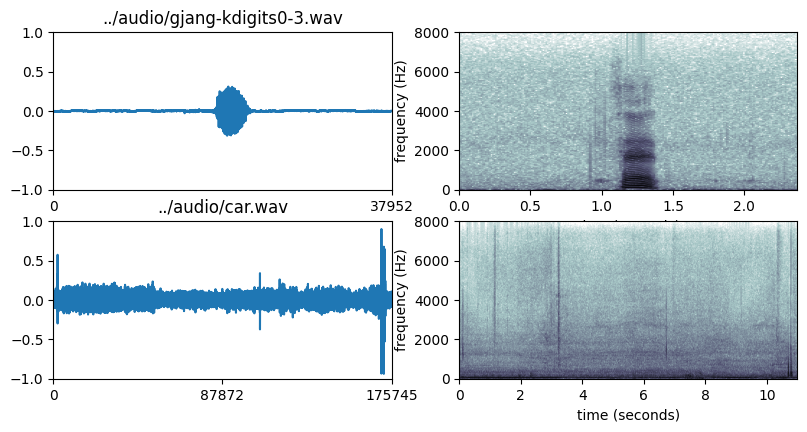

In [8]:
plt.figure(figsize=FIG_SIZE*np.array([1.2,1.5]))
plt.subplot(2,2,1)
plt.plot(speech); plt.xlim(0,len(speech)); plt.ylim(-1,1); plt.xticks([0, len(speech)])
plt.title(speechfile)
plt.subplot(2,2,2)
drawspectrogram3(speech, Fs, NFFT, Ns, minpercentile=1, isdbscale=True, isdraw=True, colormap=cmap_plot)
plt.subplot(2,2,3)
plt.plot(noise); plt.xlim(0,len(noise)); plt.ylim(-1,1); plt.xticks([0, len(noise)//2, len(noise)])
plt.title(noisefile)
plt.subplot(2,2,4)
drawspectrogram3(noise, Fs, NFFT, Ns, minpercentile=1, colormap=cmap_plot)

__generate noisy speech with various SNRs__
- 음성과 잡음의 상대적 크기에 따라 잡음의 효과를 time domain, spectrogram, 그리고 들어서 확인해 본다.

__noise gain adjustment to match the targer SNR__

1. 음성과 잡음의 상대적 크기는 SNR (signal-to-noise ratio)로 정의할 수 있다.
$$ SNR = 10 \log_{10} \frac{\sum_{t=1}^{T} s^2[t]}{\sum_{t=1}^{T} n^{2}[t]} = 20 \log_{10} \frac{\sqrt{\frac{1}{T} \sum_{t=1}^{T} s^2[t]}}{\sqrt{\frac{1}{T} \sum_{t=1}^{T} n^{2}[t]}} 
= 10 \log_{10} \frac{\langle s^2 \rangle_{T} }{ \langle n^2 \rangle_{T} }
$$
> integer index $t$ 는 sample index, $\langle \cdot \rangle_{T}$ 은 $T$개의 sample mean 을 나타낸다.
2. speech 와 noise 를 다음과 같이 normalize 한다.
$$ \sigma_{s} = \sqrt{\frac{1}{T} \sum_{t=1}^{T} s^{2} [t] } , \quad s_{\sigma = 1} [t] = \frac{s[t]}{\sigma_{s}} , 
\quad \sigma_{n} = \sqrt{\frac{1}{T} \sum_{t=1}^{T} n^{2} [t] } , \quad n_{\sigma = 1} [t] = \frac{n[t]}{\sigma_{n}}$$
3. target SNR $r$ 에 맞추기 위한 gain 계산
$$ SNR_{\sigma=1} = 20 \log_{10} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} }
= 20 \log_{10} \frac{1}{1} = 0 $$
$$ \Rightarrow r = r + SNR_{\sigma=1} 
= 20 \log_{10} 10^{r/20} + 20 \log_{10} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} } 
$$
$$ = 20 \log_{10} 10^{r/20} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} } 
= 20 \log_{10} 10^{r/20} \cdot \left\{ \frac{1/\sigma_{s}}{1/\sigma_{n}} \right\}^2
\frac{\langle s^2 \rangle_{T} }{ \langle n^2 \rangle_{T} } $$
$$ =20 \log_{10} 10^{-r/20} \left\{ \frac{\sigma_{s}}{\sigma_{n}} \right\}^2
\langle n^2 \rangle_{T} +  20 \log_{10} \langle s^2 \rangle_{T} $$
- 따라서 다음의 치환에 의해 target SNR $r$ 에 맞출 수 있다.
$$ n[t] \Leftarrow \sqrt{10^{-r/20}} \frac{\sigma_{s}}{\sigma_{n}} n[t] $$

- mixed input $x[t]$ 를 다음과 같이 생성한다.
$$ x[t] = s[t] + \sqrt{10^{-r/20}} \frac{\sigma_{s}}{\sigma_{n}} n[t] $$

Target SNR = 20 dB, gain = 0.32, Mixing SNR=20.00
Target SNR = 10 dB, gain = 0.56, Mixing SNR=10.00
Target SNR = 0 dB, gain = 1.00, Mixing SNR=-0.00
Target SNR = -10 dB, gain = 1.78, Mixing SNR=-10.00


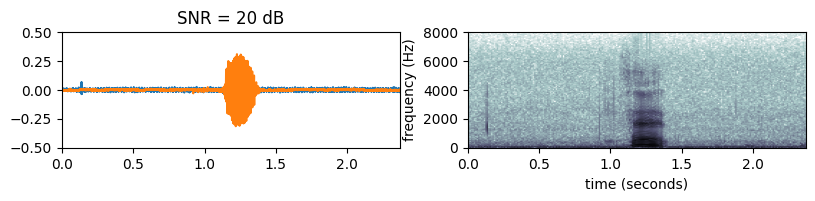

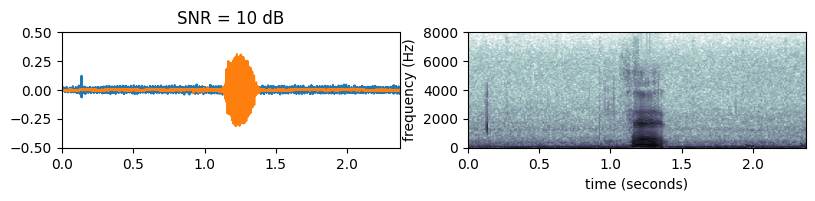

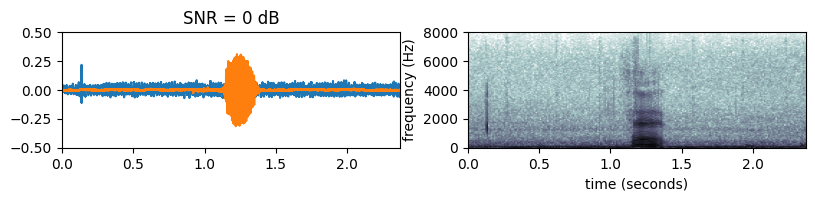

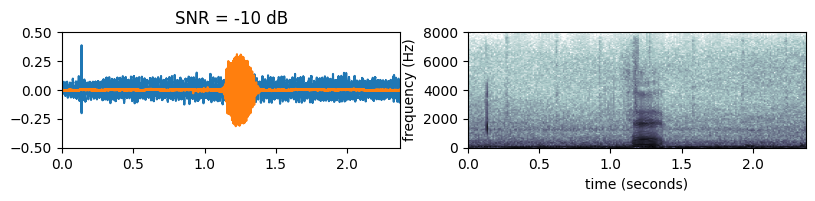

In [9]:
import gjwavile as wav

std_s = np.sqrt(np.mean(speech**2))
std_n = np.sqrt(np.mean(noise[:len(speech)]**2))
mixsnrs = np.array([20, 10, 0, -10])
mixedSig = []
mixedWavfiles = []
for snr in mixsnrs:
    gain = np.sqrt(np.power(10, -snr/20))
    gn = noise[:len(speech)]/std_n*std_s*gain
    m = speech + gn
    mixedSig.append(m)
    print('Target SNR = %.0f dB, gain = %.2f, Mixing SNR=%.2f' % (snr, gain,20*np.log10(np.sum(speech**2)/np.sum(gn**2))))
    
    # draw
    plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
    plt.subplot(1,2,1)
    xscale = np.arange(len(gn))/Fs
    plt.plot(xscale,gn); plt.plot(xscale,speech); plt.xlim(0,len(speech)/Fs); plt.ylim(-0.5,0.5)  #; plt.xticks([])
    plt.title('SNR = %.0f dB' % (snr))
    plt.subplot(1,2,2)
    drawspectrogram3(m, Fs, Nf, Ns, minpercentile=1, colormap=cmap_plot)
    
    # save the mixed file
    fname = addpath(outpath, 'mix%.fdb.wav' % (snr))
    wav.writewav(fname, Fs, m, maxval=1.0)
    mixedWavfiles.append(fname)

In [10]:
IPython.display.Audio(mixedWavfiles[0])

In [11]:
IPython.display.Audio(mixedWavfiles[1])

In [12]:
IPython.display.Audio(mixedWavfiles[2])

In [13]:
IPython.display.Audio(mixedWavfiles[3])

- 입력 음성 파일에 무음구간이 워낙 많기 때문에 음성이 상대적으로 크게 들린다. 원래 0 dB 에서는 크기가 거의 같아야 한다.
- 제대로 SNR 을 측정하기 위해서는 음성과 잡음의 무음 구간을 고려해야 한다.

Target SNR = -10 dB, gain = 1.78, Mixing SNR=-27.64


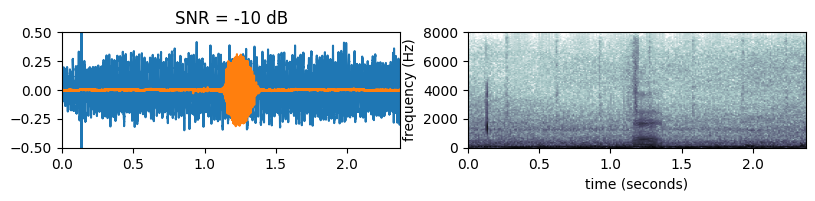

In [14]:
# 음성 존재구간을 tight 하게 잡고(1.1-1.4 sec) SNR = -10 dB 로 합성
tightinterval = (np.array([1.1, 1.4])*Fs).astype(int)
ss = speech[tightinterval[0]:tightinterval[1]]
nn = noise[tightinterval[0]:tightinterval[1]]
std_s = np.sqrt(np.mean(ss**2))
std_n = np.sqrt(np.mean(nn**2))
snr = -10
gain = np.sqrt(np.power(10, -snr/20))
gn = noise[:len(speech)]/std_n*std_s*gain
m = speech + gn
print('Target SNR = %.0f dB, gain = %.2f, Mixing SNR=%.2f' % (snr, gain,20*np.log10(np.sum(speech**2)/np.sum(gn**2))))

# draw
plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
plt.subplot(1,2,1)
xscale = np.arange(len(gn))/Fs
plt.plot(xscale,gn); plt.plot(xscale,speech); plt.xlim(0,len(speech)/Fs); plt.ylim(-0.5,0.5)  #; plt.xticks([])
plt.title('SNR = %.0f dB' % (snr))
plt.subplot(1,2,2)
_ = drawspectrogram3(m, Fs, Nf, Ns, minpercentile=1, colormap=cmap_plot)

# save the mixed file
fname = addpath(outpath, 'mixtight%.fdb.wav' % (snr))
wav.writewav(fname, Fs, m, maxval=1.0)
mixedWavfiles.append(fname)

In [15]:
IPython.display.Audio(mixedWavfiles[-1])

---
## Programming assignments: spectral subtraction and Wiener filtering, end point detectoin

1. 각각의 SNR에 대해서 잡음을 앞의 0.5 초 구간에서 추정하고 이를 차감하는 FIR 필터를 적용하여 잡음을 제거한다.
2. energy 기반 end point detectoin 을 구현한다. 
3. end point detection 으로 정확하게 구한 잡음 구간에서 잡음 스펙트럼을 추정하고 이를 차감한다.

---
## Solution

![FIR filtering with memory](figures/lab04_fig1.png)

Power spectral density (PSD) estimation
- 신호의 power spectral density는 다음과 같이 정의된다.

$$ P_{xy} = \int_{-\infty}^{\infty} 소리 신호는 시간에 따라서 변하기 때문에 

Noise spectrum estimation
1. noise 는 stationary, speech 는 non-stationary 가정
2. 처음 0.5~1초는 noise 만 있다고 가정하고 이 구간의 평균 spectral energy ($|\cdot|^2$) 을 추정

Noise spectrum estimation
1. noise 는 stationary, speech 는 non-stationary 가정
2. 처음 0.5~1초는 noise 만 있다고 가정하고 이 구간의 평균 spectral energy ($|\cdot|^2$) 을 추정

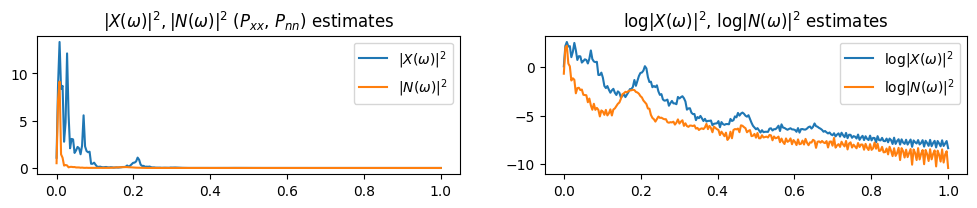

In [16]:
####################################
# 10 dB mixed speech 스펙트럼
mix = mixedSig[1]
Nx = len(mix)
nframes = int((Nx-Nf)//Ns+1)
Pxx = np.zeros(hNo)   # E[X*conj(X)]
for n in range(nframes):
    x = mix[(n*Ns):(n*Ns+Nf)]
    X = np.fft.fft(x, NFFT)
    aX2 = (X*np.conj(X))
    Pxx += aX2[:hNo].real
    
# average (E[x*conj(x)]
Pxx /= nframes

####################################
# 0-0.5초에 대하여 잡음 스펙트럼 추정
mix = mixedSig[1]
Tn = 0.5   # 0~0.5초
Nn = Tn*Fs
nframes = int((Nn-Nf)//Ns+1)
Pnn = np.zeros(hNo)   # E[N*conj(N)]
for n in range(nframes):
    x = mix[(n*Ns):(n*Ns+Nf)]
    X = np.fft.fft(x, NFFT)
    aX2 = (X*np.conj(X))
    Pnn += aX2[:hNo].real
    
# average (expected value)
Pnn = Pnn/nframes

####################################
# plot
plt.figure(figsize=FIG_SIZE*np.array([1.5,0.6]))
xticks=np.linspace(0, 1, num=hNo, endpoint=True)

plt.subplot(1,2,1)
plt.plot(xticks,Pxx,label='$|X(\omega)|^2$')
plt.plot(xticks,Pnn,label='$|N(\omega)|^2$')
plt.title('$|X(\omega)|^2, |N(\omega)|^2$ ($P_{xx}$, $P_{nn}$) estimates')
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.plot(xticks,np.log(Pxx),label='$\log |X(\omega)|^2$')
plt.plot(xticks,np.log(Pnn),label='$\log |N(\omega)|^2$')
plt.title('$\log |X(\omega)|^2$, $\log |N(\omega)|^2$ estimates')
plt.legend(loc='upper right')

In [17]:
####################################
def __sumSpect(x, I):
    #plt.figure(figsize=FIG_SIZE*np.array([1.5,0.9]))
    #plt.plot(x[I[0]:I[1]])
    Nt = I[1]-I[0]
    nframes = int((Nt-Nf)//Ns+1)
    Pxx = np.zeros(hNo)   # E[N*conj(N)]
    for n in range(nframes):
        X = np.fft.fft(x[(n*Ns+I[0]):(n*Ns+Nf+I[0])], NFFT)
        aX2 = (X*np.conj(X))
        Pxx += aX2[:hNo].real
        
    return Pxx, nframes

####################################
def estSpect(x, IntervalMulti=[]):
    # x: 1-dim time domain signal
    # IntervalMulti:  
    #   2-dim matrix, [n_interval, 2]: multiple intervals
    #   empty list: use all x
    if len(IntervalMulti) == 0:
        IntervalMulti = np.array([[0, len(x)]])
    #print(IntervalMulti, IntervalMulti.shape)
    
    # accumulate interval power spectral densities
    PxxSum = np.zeros(hNo)   # E[N*conj(N)]
    NumFrames = 0
    for ii in range(IntervalMulti.shape[0]):
        [Pxx, N] = __sumSpect(x, IntervalMulti[ii,:].astype(int))
        PxxSum = PxxSum + Pxx
        NumFrames += N
        
    # average (E[x*conj(x)]
    return PxxSum/NumFrames

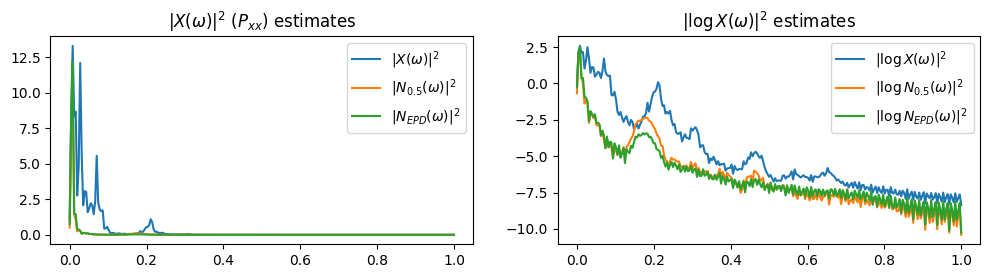

In [18]:
####################################
mix = mixedSig[1]
PxxAll = estSpect(mix, [])
#PxxEPD = estSpect(mix, np.array([[1.1, 1.4]])*Fs)
#PssEPD = estSpect(speech, np.array([[1.1, 1.4]])*Fs)
PnnHead = estSpect(mix, np.array([[0.0, 0.5]])*Fs)
PnnEPD = estSpect(mix, np.array([[0,1.0], [1.5, 2.0], [2.0, 2.2]])*Fs)

####################################
# plot
plt.figure(figsize=FIG_SIZE*np.array([1.5,0.9]))
xticks=np.linspace(0, 1, num=hNo, endpoint=True)

plt.subplot(1,2,1)
plt.plot(xticks,PxxAll,label='$|X(\omega)|^2$')
plt.plot(xticks,PnnHead,label='$|N_{0.5}(\omega)|^2$')
plt.plot(xticks,PnnEPD,label='$|N_{EPD}(\omega)|^2$')
#plt.plot(xticks,PssEPD,label='$|S(\omega)|^2$')
plt.title('$|X(\omega)|^2$ ($P_{xx}$) estimates')
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.plot(xticks,np.log(PxxAll),label='$|\log X(\omega)|^2$')
plt.plot(xticks,np.log(PnnHead),label='$|\log N_{0.5}(\omega)|^2$')
plt.plot(xticks,np.log(PnnEPD),label='$|\log N_{EPD}(\omega)|^2$')
#plt.plot(xticks,np.log(PssEPD),label='$|\log S(\omega)|^2$')
plt.title('$|\log X(\omega)|^2$ estimates')
plt.legend(loc='upper right')

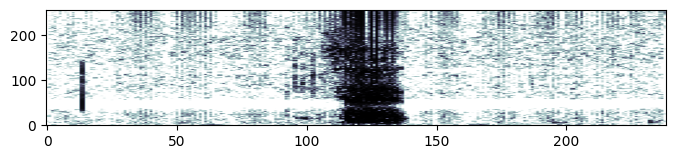

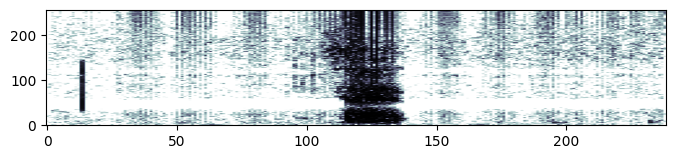

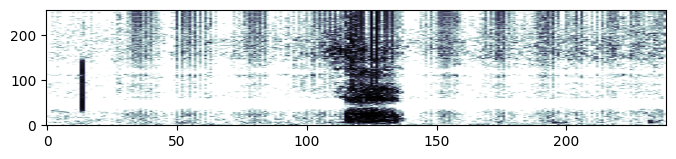

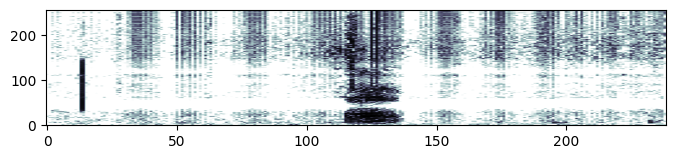

In [19]:
order = 30
noverlap = int(Fs*0.003)   # 3ms

#minwfgain = 10**(-13/20)    # 0.228
minwfgain = 10**(-20/20)    # 0.1

fola = firoverlapadd()
fola.set(Ns=Ns, Nov=noverlap, order=order, FIRshift=order//2)

# overlap add 를 할 때는 10ms 씩 shift 해야 한다.
xbuf = np.zeros(Nf)
speechest = []
for mix in mixedSig:
    Pnn = estSpect(mix, np.array([[0.0, 0.5]])*Fs)
    
    Tx = len(mix)
    yout = np.zeros(Nx+fola.getDelay())
    Lout = 0
    xbuf[:] = 0
    t = 0  # time index
    H_a = np.zeros((hNo,0))   # for drawing
    while True:
        t1 = min(t,Nx)      # 시작 샘플, 마지막 샘플인덱스보다는 작아야 함
        t2 = min(t+Ns,Nx)   # 끝 샘플, 마지막 샘플인덱스보다는 작아야 함
        
        for ii in range(Nf-Ns):
            xbuf[ii] = xbuf[ii+Ns]
        xbuf[(Nf-Ns):] = 0
        for ii in range(t2-t1):
            xbuf[(Nf-Ns)+ii] = mix[t1+ii]
        X = np.fft.fft(xbuf, NFFT)
        aX2 = (X*np.conj(X))
        Pxx = aX2[:hNo].real
        Pxx = np.maximum(1e-100, Pxx)  # to prevent divide by zero
        H = (Pxx-Pnn)/Pxx
        H = np.maximum(minwfgain, H)
        '''
        if t<Ns*10:
            plt.figure(figsize=FIG_SIZE*np.array([1.2,0.9]))
            #plt.plot(H)
            plt.plot(Pxx)
            plt.plot(Pnn)
            plt.plot(Pxx-Pnn)
        '''
        H_a = np.column_stack([H_a, np.expand_dims(H,axis=1)])

        h, _ = getLPHFIRFFT(H, order, winname='hamming')
        x = mix[t1:t2]
        y, l = fola.doFilterMem(h,x)
        if l > len(yout)-Lout:
            print(len(yout), Lout, len(yout)-Lout, Lout, l)
            l = len(yout)-Lout            
        if l <= 0: break
        
        yout[Lout:(Lout+l)] = y[:l]
        Lout += l
        t += Ns
        
    speechest.append(yout)
    plt.figure(figsize=FIG_SIZE*np.array([1.0,0.5]))
    plt.imshow(H_a, cmap=cmap_plot, aspect='auto', origin='lower')    

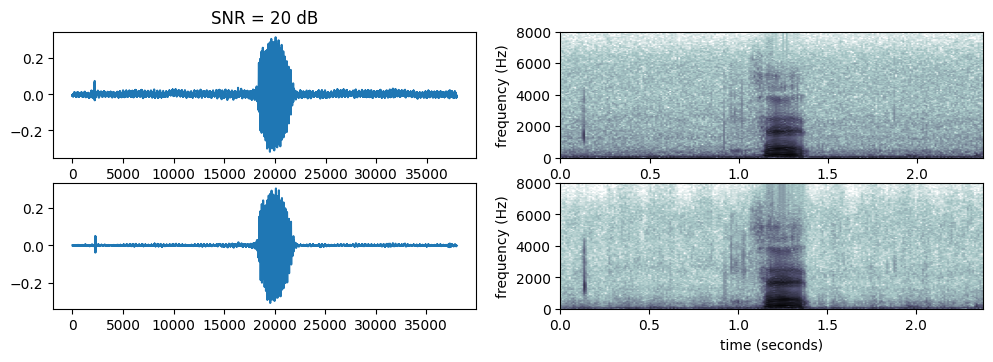

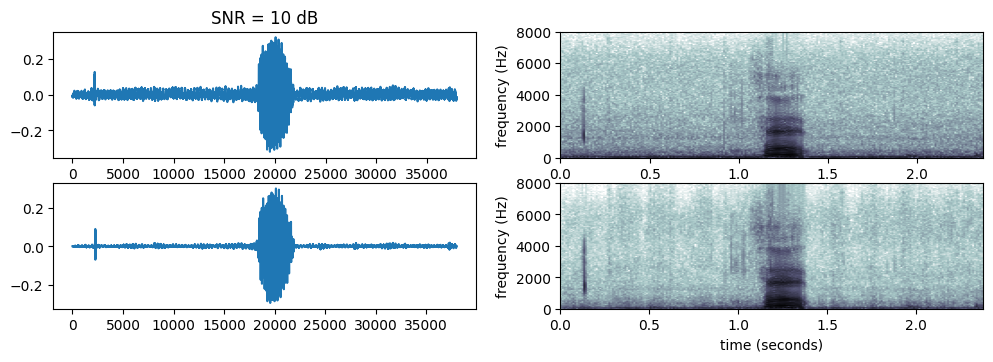

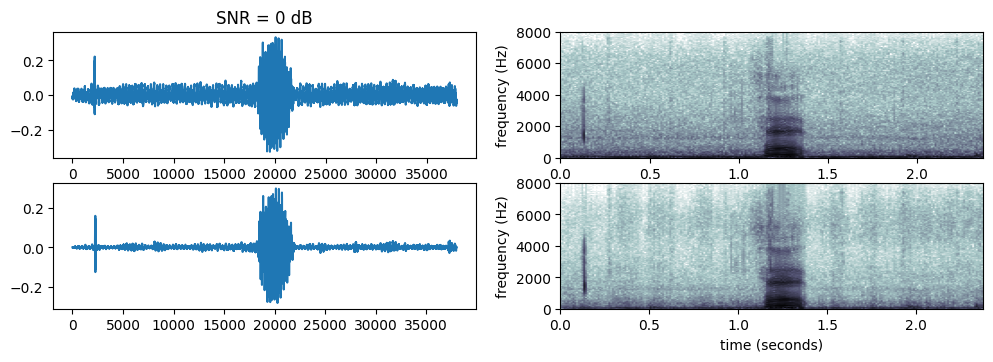

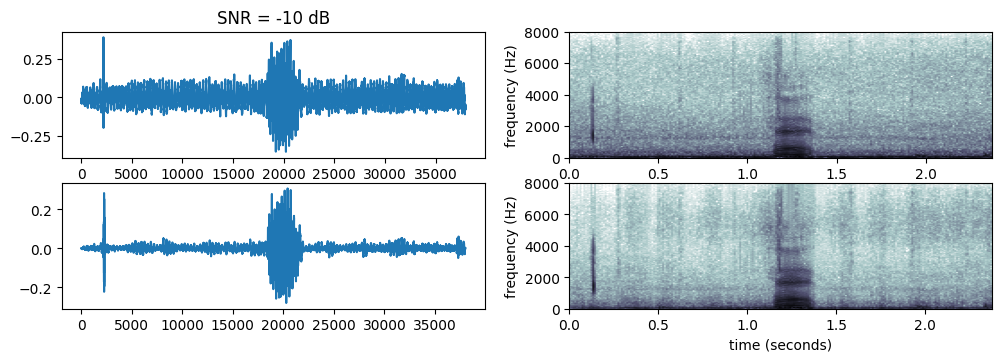

In [31]:
nsWavfiles = []
for m in range(len(mixedSig)):
    plt.figure(figsize=FIG_SIZE*np.array([1.5,1.2]))
    plt.subplot(2,2,1)
    plt.plot(mixedSig[m])
    plt.title('SNR = %.0f dB' % (mixsnrs[m]))
    plt.subplot(2,2,2)
    drawspectrogram3(mixedSig[m], Fs, Nf, Ns, minpercentile=1, isdbscale=True, isdraw=True)
    plt.subplot(2,2,3)
    plt.plot(speechest[m])
    plt.subplot(2,2,4)
    drawspectrogram3(speechest[m], Fs, Nf, Ns, minpercentile=1, isdbscale=True, isdraw=True)
    
    # save the noise suppressed audio file
    fname = addpath(outpath, 'ns%.fdb.wav' % (mixsnrs[m]))
    wav.writewav(fname, Fs, speechest[m], maxval=1.0)
    nsWavfiles.append(fname)

- mixed sound 와 noise suppressed sound 를 들어보자

In [21]:
IPython.display.Audio(mixedWavfiles[0])

In [22]:
IPython.display.Audio(nsWavfiles[0])

In [23]:
IPython.display.Audio(mixedWavfiles[1])

In [24]:
IPython.display.Audio(nsWavfiles[1])

In [25]:
IPython.display.Audio(mixedWavfiles[2])

In [26]:
IPython.display.Audio(nsWavfiles[2])

In [27]:
IPython.display.Audio(mixedWavfiles[3])

In [28]:
IPython.display.Audio(nsWavfiles[3])

.

## End of Lab 04

__generate noisy speech with various SNRs__
- 음성과 잡음의 상대적 크기에 따라 잡음의 효과를 time domain, spectrogram, 그리고 들어서 확인해 본다.

1. 음성과 잡음의 상대적 크기는 SNR (signal-to-noise ratio)로 정의할 수 있다.
$$ SNR = 10 \log_{10} \frac{\sum_{t=1}^{T} s^2[t]}{\sum_{t=1}^{T} n^{2}[t]} = 20 \log_{10} \frac{\sqrt{\frac{1}{T} \sum_{t=1}^{T} s^2[t]}}{\sqrt{\frac{1}{T} \sum_{t=1}^{T} n^{2}[t]}} 
= 10 \log_{10} \frac{\langle s^2 \rangle_{T} }{ \langle n^2 \rangle_{T} }
$$
> integer index $t$ 는 sample index, $\langle \cdot \rangle_{T}$ 은 $T$개의 sample mean 을 나타낸다.
2. 목표 SNR 에 맞추기 위하여 speech 와 noise 를 다음과 같이 normalize 한다.
$$ \sigma_{s} = \sqrt{\frac{1}{T} \sum_{t=1}^{T} s^{2} [t] } , \quad s_{\sigma = 1} [t] = \frac{s[t]}{\sigma_{s}} , 
\quad \sigma_{n} = \sqrt{\frac{1}{T} \sum_{t=1}^{T} n^{2} [t] } , \quad n_{\sigma = 1} [t] = \frac{n[t]}{\sigma_{n}}$$
3. target SNR $r$ 에 맞추기 위한 gain 계산
$$ SNR_{\sigma=1} = 20 \log_{10} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} }
= 20 \log_{10} \frac{1}{1} = 0 $$
$$ \Rightarrow r = r + 20 \log_{10} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} }
= 20 \log_{10} 10^{r/20} + 20 \log_{10} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} } 
$$
$$ = 20 \log_{10} 10^{r/20} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} } 
= 20 \log_{10} 10^{r/20} \left\{ \frac{\sigma_{s}}{\sigma_{n}} \right\}^2
\frac{\langle s^2 \rangle_{T} }{ \langle n^2 \rangle_{T} } 
= 20 \log_{10} 10^{r/20} \left\{ \frac{\sigma_{s}}{\sigma_{n}} \right\}^2
\frac{\langle s^2 \rangle_{T} }{ \langle n^2 \rangle_{T} } $$
- 따라서 다음의 치환에 의해 target SNR $r$ 에 맞출 수 있다.
$$ n[t] \Leftarrow \sqrt{10^{r/20}} \frac{\sigma_{s}}{\sigma_{n}} n[t] $$



$$ \Rightarrow 20 \log_{10} 10^{r/20} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} }
= 20 \log_{10} 10^{r/20} + 20 \log_{10} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} } = r$$
$$ \Rightarrow 20 \log_{10} 10^{r/20} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} } 
= 20 \log_{10} 10^{r/20} \left\{ \frac{\sigma_{s}}{\sigma_{n}} \right\}^2$$

$$ \Rightarrow 20 \log_{10} 10^{r/20} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} }
= 20 \log_{10} 10^{r/20} \left{\frac{sigma_{s}}{sigma_{n}}}^2 \right}^2 {\langle s^2 \rangle_{T} }{ \langle n^2 \rangle_{T} $$




\frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} }

= 20 \log_{10} 10^{r/20} + 20 \log_{10} \frac{\langle s_{\sigma=1}^2 \rangle_{T} }{ \langle n_{\sigma=1}^2 \rangle_{T} } = r$$


\frac{\sqrt{\frac{1}{T} \sum_{t=1}^{T} s_{\sigma = 1}^2[t]}}{\sqrt{\frac{1}{T} \sum_{t=1}^{T} n_{\sigma = 1}^{2}[t]}} = SNR $$


$$ SNR_{\sigma=1} = 20 \log_{10} \frac{\sqrt{\frac{1}{T} \sum_{t=1}^{T} s_{\sigma = 1}^2[t]}}{\sqrt{\frac{1}{T} \sum_{t=1}^{T} n_{\sigma = 1}^{2}[t]}} = 0 $$
$$ \Rightarrow 20 \log_{10} 10^{SNR/20} \frac{\sqrt{\frac{1}{T} \sum_{t=1}^{T} s_{\sigma = 1}^2[t]}}{\sqrt{\frac{1}{T} \sum_{t=1}^{T} n_{\sigma = 1}^{2}[t]}} = SNR $$


\sqrt{\frac{1}{T} \sum_{t=1}^{T} s^{2} [t] } , \quad s_{\sigma = 1} [t] = \frac{s[t]}{\sigma_{s}}$$
$$ \sigma_{n} = \sqrt{\frac{1}{T} \sum_{t=1}^{T} n^{2} [t] } , \quad n_{\sigma = 1} [t] = \frac{n[t]}{\sigma_{n}}$$

\quad g(SNR) = 10^{-SNR/20} , 
\quad n_{SNR} [t] = g(SNR) \frac{n[t]}{\sigma_{n}}$$
- mixed input $x[t]$ 를 다음과 같이 생성한다.


- noise gain 을 조정하여 SNR 에 맞춘다.
$$ \sigma_{n} = \sqrt{\frac{1}{T} \sum_{t=1}^{T} n^{2} [t] } , \quad g(SNR) = 10^{-SNR/20} , 
\quad n_{SNR} [t] = g(SNR) \frac{n[t]}{\sigma_{n}}$$
- mixed input $x[t]$ 를 다음과 같이 생성한다.
$$ x[t] = s[t] + g(SNR) \frac{n[t]}{\sigma_{n}}$$